# Overfitting on fully observed 10k population
- this notebook serves to check whether we can actually obtain a fit good enough to 'beat' ground-truth in large systems (p > 10k)
- the underlying concern is that gradient quality might be too low : we approximate pxp matrices as rank 1, and the rank-discrepancy grows with system size if there is noise on the matrices
- here we fit the moment-matching model to LDS data, using only a single time-lag for simplicity
- signal-to-noise ratio R_ii/Var(C_i * x * C_i') = 1, i.e. the ground-truth parameters are not perfect and we can actually overfit

Remark: The depicted intermediate fitting results do not reflect the whole fitting process - the cell [65] was run repeatedly, playing extensively with step-sizes and later also with batch-sizes. The shown results are only from the last run of the cell. The trace of the last $20*50=1000$ gradient steps indicates we could have improved the fit even further

Remark: The fit below was the *second* attempt. The first random initialisation could *not* be brought to the same quality as grount-truth parameters (absolut zero of loss function is not attainable due to non-zero emission noise and finite sample-size). Could be due to some wierd function landscape around the initialisation that was slow to escape, or because the algorithm indeed does not converge globally. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import glob, os, psutil, time

os.chdir('../core')
import ssm_scripts, ssm_fit
from utility import get_subpop_stats, gen_data
from SSID_Hankel_loss import run_bad, plot_slim, print_slim
os.chdir('../dev')

#np.random.seed(0)

# define problem size
p, n, T = 10500, 20, 2000
lag_range = np.arange(0, 1)
kl_ = np.max(lag_range)+1

# I/O matter
mmap, chunksize = True, np.min((p,2000))
data_path, save_file = '../fits/', 'test'
verbose=True

# draw system matrices 
print('(p,n,k+l,T) = ', (p,n,len(lag_range),T), '\n')
nr = 0 # number of real eigenvalues
snr = (1., 1.)
eig_m_r, eig_M_r, eig_m_c, eig_M_c = 0.8, 0.95, 0.8, 0.95
pars_true, x, y, Qs, idx_a, idx_b = gen_data(p,n,lag_range,T, nr,
                                             eig_m_r, eig_M_r, 
                                             eig_m_c, eig_M_c,
                                             mmap, chunksize,
                                             data_path,snr=snr)    

print('\n')
print(psutil.virtual_memory())
print(psutil.swap_memory())


(p,n,k+l,T) =  (10500, 20, 1, 2000) 

computing empirical covariances
......
   0.34sec avg, 2.04 total

computing time-lagged covariance for lag  0


svmem(total=12277600256, available=5227786240, percent=57.4, used=8400252928, free=3877347328, active=6964944896, inactive=788697088, buffers=49512448, cached=1300926464, shared=545927168)
sswap(total=0, used=0, free=0, percent=0, sin=0, sout=0)


# peek at data & observation scheme

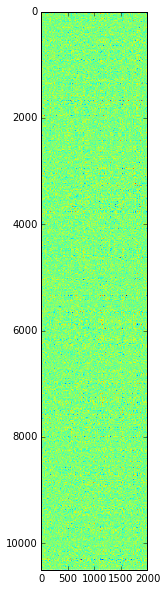

In [2]:
%matplotlib inline

# create subpopulations
sub_pops = (np.arange(0,p),) 


#assert(p==105)
#sub_pops = (np.arange(0,25), np.arange(20,45),np.arange(40,65),np.arange(60,85),np.arange(80,105))

obs_sweeps = 1

#assert(p==105)
#sub_pops = (np.arange(0,55),np.arange(50,p)) 

obs_pops = np.hstack([np.arange(len(sub_pops)) for i in range(obs_sweeps)])
obs_time = np.array([i*T//len(obs_pops) for i in range(1,len(obs_pops)+1)])


obs_idx, idx_grp, co_obs, _, _, _, Om, _, _ = \
    get_subpop_stats(sub_pops=sub_pops, p=p, verbose=False)


y_masked = np.memmap(data_path+'y', dtype=np.float, mode='c', shape=(T,p))
y_masked[:obs_time[0], np.setdiff1d(np.arange(p), sub_pops[obs_pops[0]])] = np.nan
for i in range(1,len(obs_time)):
    y_masked[np.ix_(np.arange(obs_time[i-1],obs_time[i]), np.setdiff1d(np.arange(p), sub_pops[obs_pops[i]]))] = np.nan
plt.figure(figsize=(20,10))
plt.imshow(y_masked.T, interpolation='None')
plt.show()

y_masked = np.memmap(data_path+'y', dtype=np.float, mode='c', shape=(T,p))
y_masked[:obs_time[0], np.setdiff1d(np.arange(p), sub_pops[obs_pops[0]])] = 0
for i in range(1,len(obs_time)):
    y_masked[np.ix_(np.arange(obs_time[i-1],obs_time[i]), np.setdiff1d(np.arange(p), sub_pops[obs_pops[i]]))] = 0
del y
y = np.memmap(data_path+'y', dtype=np.float, mode='r', shape=(T,p))


# peek at latent covariances

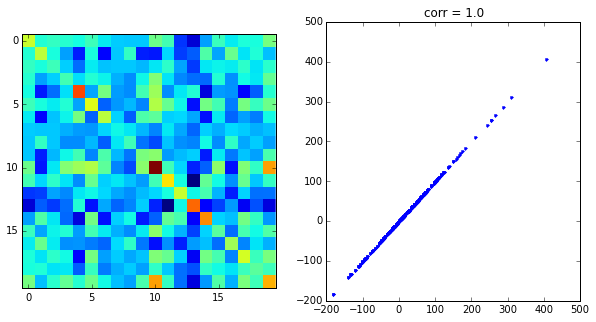

In [3]:

plt.figure(figsize=(10,len(sub_pops)*5))

idx = np.array([],dtype=np.int)
for j in np.where(obs_pops==0)[0]:
    idxj = np.arange(obs_time[j-1],obs_time[j],dtype=np.int) if j > 0 else np.arange(obs_time[j],dtype=np.int)
    idx = np.hstack((idx, idxj)) 
cov_1 = np.cov(x[idx,:].T)

for i in range(len(sub_pops)):
    plt.subplot(len(sub_pops),2,2*i+1)
    idx = np.array([],dtype=np.int)
    for j in np.where(obs_pops==i)[0]:
        idxj = np.arange(obs_time[j-1],obs_time[j],dtype=np.int) if j > 0 else np.arange(obs_time[j],dtype=np.int)
        idx = np.hstack((idx, idxj)) 
    cov_i = np.cov(x[idx,:].T)
    plt.imshow(cov_i, interpolation='None')
    plt.subplot(len(sub_pops),2,2*i+2)
    plt.plot(cov_1.reshape(-1), cov_i.reshape(-1), '.')
    plt.title('corr = ' + str(np.corrcoef(cov_1.reshape(-1), cov_i.reshape(-1))[0,1]))
plt.show()

# fit 

In [28]:
cheat = False
if cheat:
    pars_est = pars_true.copy()  
    pars_est['X'] = np.zeros((len(lag_range)*n, n))
    for i in range(len(lag_range)):
        pars_est['X'][i*n:(i+1)*n,:] = np.linalg.matrix_power(pars_est['A'],lag_range[i]).dot(pars_est['Pi'])
        
else: 
    pars_est = 'default'

In [65]:
%matplotlib inline

# settings for fitting algorithm
batch_size, max_zip_size, max_iter = 10, 50, 20
a, b1, b2, e = 0.001, 0.9, 0.99, 1e-8
a_R = 10 * a

t = time.time()
_, pars_est, traces = run_bad(lag_range=lag_range,n=n,y=y_masked, Qs=Qs,Om=Om,idx_a=idx_a, idx_b=idx_b,
                                      sub_pops=sub_pops,idx_grp=idx_grp,co_obs=co_obs,obs_idx=obs_idx,
                                      obs_pops=obs_pops,obs_time=obs_time,init=pars_est,
                                      alpha_C=a,alpha_R=a_R,b1_C=b1,b2_C=b2,e_C=e,max_iter=max_iter,batch_size=batch_size,
                                      verbose=verbose, max_zip_size=max_zip_size)

print('fitting time was ', time.time() - t, 's')
print('\n')
print(psutil.virtual_memory())
print(psutil.swap_memory())

print_slim(Qs,lag_range,pars_est,idx_a,idx_b,traces,mmap,data_path)

#plot_slim(Qs,lag_range,pars_est,idx_a,idx_b,traces,mmap,data_path)



starting descent
subsampling in time!
..................................................
   0.37sec avg, 18.70 total

finished % 10.0
f =  88851752.088
..................................................
   0.40sec avg, 20.05 total

..................................................
   0.40sec avg, 19.86 total

finished % 20.0
f =  84462946.7904
..................................................
   0.40sec avg, 19.81 total

..................................................
   0.39sec avg, 19.67 total

finished % 30.0
f =  80597852.4816
..................................................
   0.40sec avg, 19.76 total

..................................................
   0.40sec avg, 19.77 total

finished % 40.0
f =  76922132.4966
..................................................
   0.40sec avg, 19.87 total

..................................................
   0.42sec avg, 20.75 total

finished % 50.0
f =  75468990.8015
..................................................
   0.40sec avg, 1

In [66]:
_, _, _ = run_bad(lag_range=lag_range,n=n,y=y_masked, Qs=Qs,Om=Om,idx_a=idx_a, idx_b=idx_b,
                                      sub_pops=sub_pops,idx_grp=idx_grp,co_obs=co_obs,obs_idx=obs_idx,
                                      obs_pops=obs_pops,obs_time=obs_time,init=pars_est,
                                      alpha_C=0,alpha_R=0,b1_C=b1,b2_C=b2,e_C=e,max_iter=1,batch_size=1,
                                      verbose=verbose, max_zip_size=1)

pars=pars_est
tmp =  pars['C'][idx_a,:].dot(pars['X'][:n,:]).dot(pars['C'][idx_b,:].T) + np.diag(pars['R'])[np.ix_(idx_a,idx_b)]
np.sum((tmp - Qs[0])**2)

starting descent
subsampling in time!
.
   0.05sec avg, 0.05 total

finished % 10.0
f =  68388622.5916
total iterations:  1


/home/mackelab/Desktop/Projects/Stitching/code/le_stitch/python/core/SSID_Hankel_loss.py:256: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(t_iter,max_iter//10) == 0:


memmap(61564424.18364232)

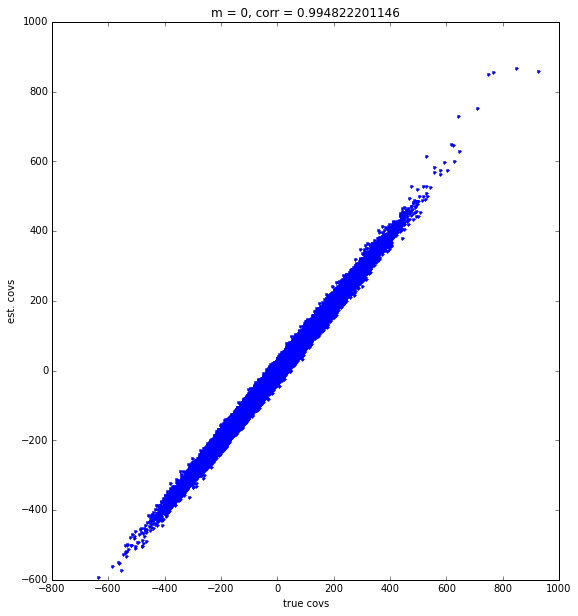

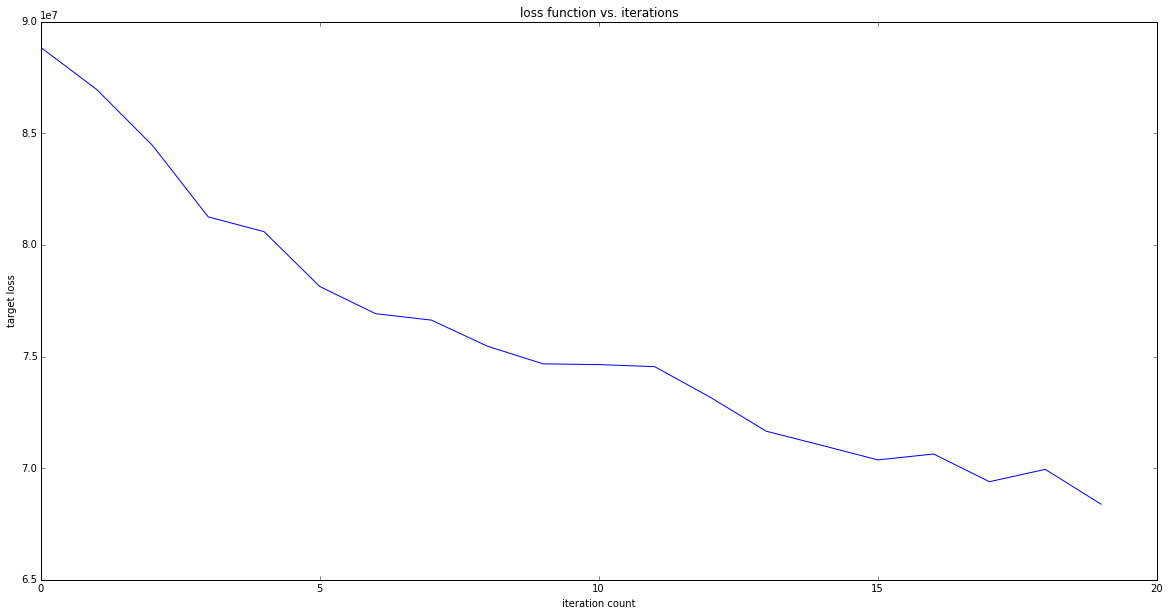

In [67]:
plot_slim(Qs,lag_range,pars_est,idx_a,idx_b,traces,mmap,data_path)

# compare to PCA

/home/mackelab/anaconda3/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


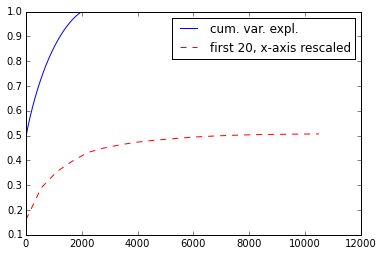

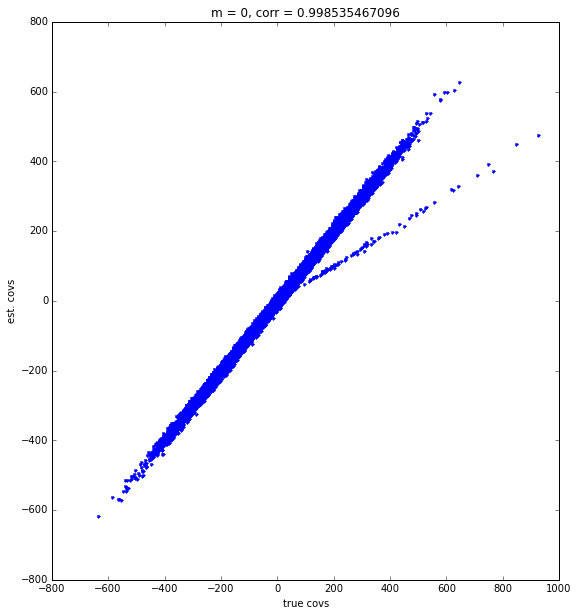

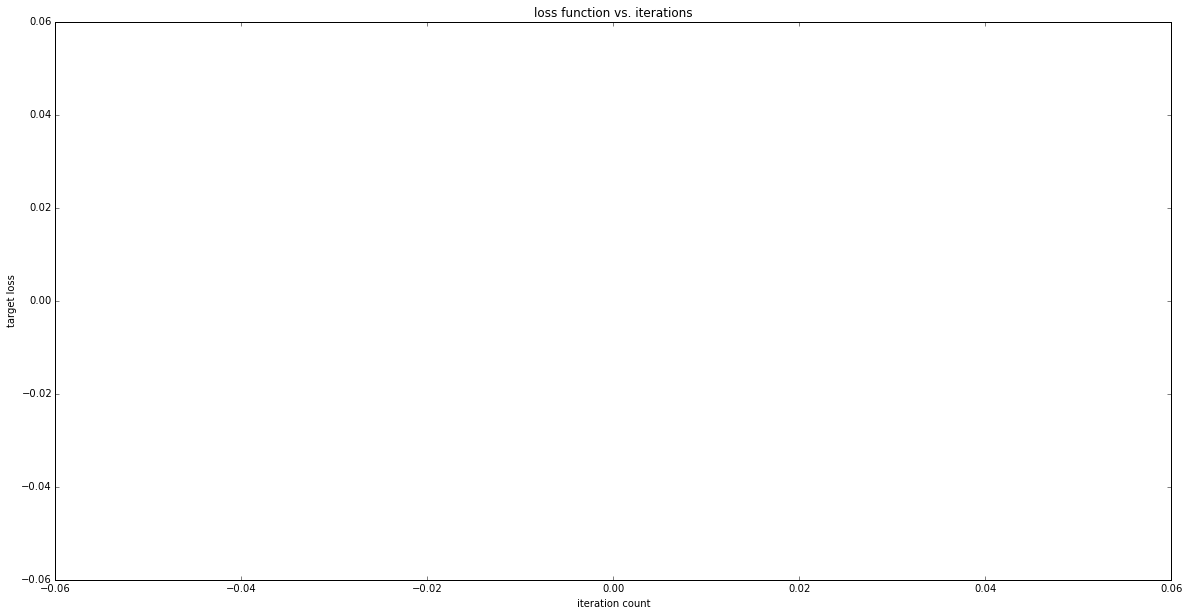

In [61]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(y_masked)
explained_variance_ratio_ = np.hstack((pca.explained_variance_ratio_, np.zeros(np.max((p-T,0)))))
plt.plot(range(1,p+1), np.cumsum(explained_variance_ratio_)/np.sum(explained_variance_ratio_))
plt.hold(True)
plt.plot(np.linspace(0,p+1,np.min((20,p))), 
         np.cumsum(pca.explained_variance_ratio_[:np.min((20,p))])/np.sum(pca.explained_variance_ratio_), 
         'r--')
plt.legend(('cum. var. expl.', 'first 20, x-axis rescaled'))

pars_pca = {}
pars_pca['C'] = pca.components_[:n].T
pars_pca['Pi'] = np.diag(pca.explained_variance_[:n])    
pars_pca['X'] = np.vstack([pars_pca['Pi'] for m in range(len(lag_range))])
pars_pca['R'] = np.zeros(p)
plot_slim(Qs,lag_range,pars_pca,idx_a,idx_b,(0,0),mmap,data_path)

# compare to FA

In [ ]:
%matplotlib inline
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis()
fa.noise_variance_init=pars_true['R']
fa.fit(y_masked)
pars_fa = {}
pars_fa['C'] = fa.components_[:n].T
pars_fa['Pi'] = np.eye(n)
pars_fa['X'] = np.vstack([pars_fa['Pi'] for m in range(len(lag_range))])
pars_fa['R'] = fa.noise_variance_
plot_slim(Qs,lag_range,pars_fa,idx_a,idx_b,(0,0),mmap,data_path)


# compare to ground-truth parameters

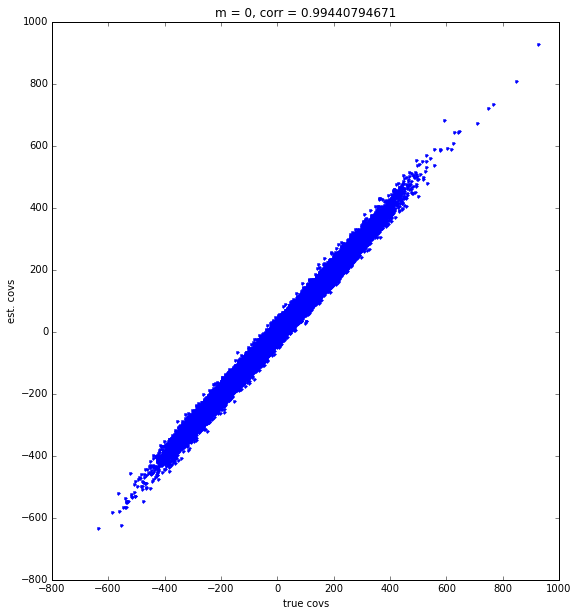

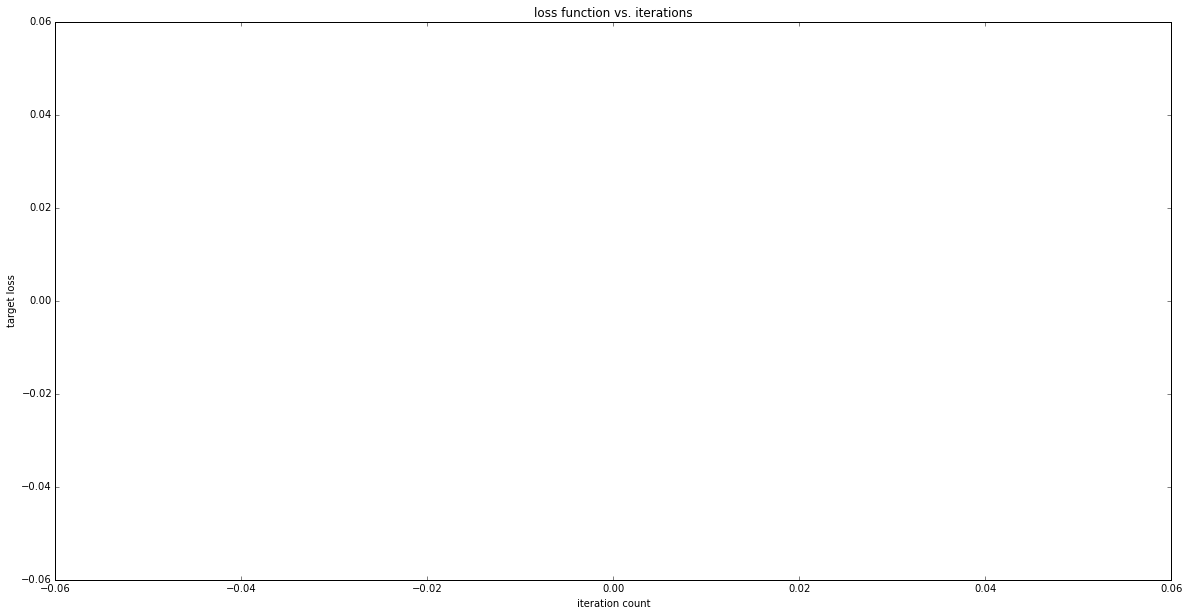

In [62]:
pars_true['X'] = np.zeros((len(lag_range)*n, n))
for i in range(len(lag_range)):
    pars_true['X'][i*n:(i+1)*n,:] = np.linalg.matrix_power(pars_true['A'],lag_range[i]).dot(pars_true['Pi'])

plot_slim(Qs,lag_range,pars_true,idx_a,idx_b,(0,0),mmap,data_path)


In [63]:
_, _, traces = run_bad(lag_range=lag_range,n=n,y=y_masked, Qs=Qs,Om=Om,idx_a=idx_a, idx_b=idx_b,
                       sub_pops=sub_pops,idx_grp=idx_grp,co_obs=co_obs,obs_idx=obs_idx,
                       obs_pops=obs_pops,obs_time=obs_time,init=pars_true,
                       alpha_C=0,max_iter=1,batch_size=1,
                       max_zip_size=1)

print_slim(Qs,lag_range,pars_true,idx_a,idx_b,traces,mmap,data_path)

#plot_slim(Qs,lag_range,pars_est,idx_a,idx_b,traces,mmap,data_path)

pars=pars_true
tmp =  pars['C'][idx_a,:].dot(pars['X'][:n,:]).dot(pars['C'][idx_b,:].T) + np.diag(pars['R'])[np.ix_(idx_a,idx_b)]
np.sum((tmp - Qs[0])**2)

starting descent
subsampling in time!
.
   0.04sec avg, 0.04 total

finished % 10.0
f =  71157484.3243
total iterations:  1
m = 0, corr = 0.99440794671


/home/mackelab/Desktop/Projects/Stitching/code/le_stitch/python/core/SSID_Hankel_loss.py:256: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(t_iter,max_iter//10) == 0:


memmap(65522184.46018157)

In [ ]:
from scipy.io import savemat
savemat(data_path+'parameters', {'Cest':pars_est['C'], 'Cfa':pars_fa['C'], 'Cpca':pars_pca['C'],'C':pars_true['C']})

# check details

In [ ]:
idx_i = 0
idxc_a = sub_pops[idx_i]
if len(sub_pops) > 0:
    idxc_b = np.setdiff1d(np.arange(p), sub_pops[idx_i]) # those only in subpop #2 
else:
    idxc_b = idx_a.copy()
idxc_b = idx_a.copy()
    
pa, pb = len(idxc_a), len(idxc_b)


Qsc = []
m_range = range(len(lag_range))
corrs_est = np.zeros((len(m_range), 2))
MSE_est = np.zeros((len(m_range), 2))    
for m in m_range:
    m_ = lag_range[m]
    print('computing time-lagged covariance for lag ', str(m_))
    Qsc.append(None)
    if mmap:
        Q = np.memmap(data_path+'Qsc_'+str(m_), dtype=np.float, 
                      mode='w+', shape=(pa,pb))
    else:
        Q = np.empty((pa,pb))
    Q[:] = np.cov(y[m_:m_-(kl_),idxc_a].T, y[:-(kl_),idxc_b].T)[:pa,pa:]     
    if mmap:
        del Q
        Qsc[m] = np.memmap(data_path+'Qsc_'+str(m_), dtype=np.float, 
                          mode='r', shape=(pa,pb))
    else:
        Qsc[m] = Q
            
    Q = (pars_est['C'][idxc_a,:].dot(pars_est['X'][m*n:(m+1)*n,:]).dot(pars_est['C'][idxc_b,:].T))
    if m_ == 0:
        Q += np.diag(pars_est['R'])[np.ix_(idxc_a, idxc_b)]
    corrs_est[m,0] = np.corrcoef(Qsc[m][:].reshape(-1), Q.reshape(-1))[0,1]
    MSE_est[m,0] = np.mean( (Qsc[m] - Q)**2 )
    
plt.figure(figsize=(11,6))
ax = plt.subplot(121)
plt.bar(-.4+np.arange(len(m_range)), corrs_est[:,0], color='r')
plt.hold(True)
plt.bar(-.4+np.arange(len(m_range))+.1, corrs_est[:,1], color='b')
plt.xticks(np.arange(len(m_range)), [str(x) for x in lag_range], fontsize=14)
#plt.yticks(np.arange(0,1.01, 0.2), fontsize=14)
plt.xlabel('time-lag')
plt.ylabel('correlation')
plt.box('off')
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

ax = plt.subplot(122)
plt.bar(-.4+np.arange(len(m_range))+.1, MSE_est[:,1], color='b')
plt.hold(True)
plt.bar(-.4+np.arange(len(m_range)), MSE_est[:,0], color='r')
plt.xticks(np.arange(len(m_range)), [str(x) for x in lag_range], fontsize=14)
#plt.yticks(np.arange(0,0.0013,0.0004), fontsize=14)
plt.xlabel('time-lag')
plt.ylabel('MSE')
plt.box('off')
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
plt.show()

plt.figure()
plt.plot(Q.reshape(-1), Qsc[m].reshape(-1), '.')
plt.hold(True)
plt.plot(Qsc[m].reshape(-1), Qsc[m].reshape(-1), 'k.')
plt.show()